I assume that you have downloaded Groove MIDI dataset and uncompssed into `./midi_dataset/groove/` folder  
https://magenta.tensorflow.org/datasets/groove 

or you can use the following MIDI archive a reddit user has collected (it contains more than 800k drum midi pattern!). If you want to try this archive, uncompress into `./midi_dataset/gm_reddit/` folder.
https://www.reddit.com/r/WeAreTheMusicMakers/comments/3anwu8/the_drum_percussion_midi_archive_800k/ 

In [8]:
from glob import glob
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

#filepaths = glob("./midi_dataset/groove/*/*/*beat_4-4.mid")
filepaths = glob("./midi_dataset/gm_reddit/GM MIDI Pack/GM - Electronic/*/*/*.mid")
#filepaths.extend(filepaths2)

print(len(filepaths))

12991


In [5]:
DRUM_CLASSES = [
   'Kick',
   'Snare',
   'Hi-hat closed',
   'Hi-hat open',
   'Tom low',
   'Tom mid', 
   'Tom high',
   'Clap',
   'Rim' 
]

# MIDI_DRUM_MAP = {
#     36: 0,
#     38: 1,
#     40: 1,
#     37: 1,
#     48: 5,
#     50: 6,
#     45: 4,
#     47: 5,
#     43: 4,
#     58: 4,
#     46: 3,
#     26: 3,
#     42: 2,
#     22: 2,
#     44: 2,
#     49: 7,
#     55: 7,
#     57: 7,
#     52: 7,
#     51: 8,
#     59: 8,
#     53: 8 
# }

# ## if you want to use reddit dataset, uncomment this
# MIDI_DRUM_MAP = {
#     36: 0,
#     35: 0,
#     38: 1,
#     40: 1,
#     42: 2, # closed hihat
#     44: 3, # pedal hihat
#     46: 3, # open hihat
#     41: 4, # low floor tom
#     45: 4, # low tom
#     47: 
#    27: 1,
#    28: 1,
#    31: 1,
#    32: 1,
#    33: 1,
#    34: 1,
#    37: 1,
#    39: 1,
#    40: 1,
#    56: 1,
#    65: 1,
#    66: 1,
#    75: 1,
#    85: 1,
#    42: 2,
#    44: 2,
#    54: 2,
#    68: 2,
#    69: 2,
#    70: 2,
#    71: 2,
#    73: 2,
#    78: 2,
#    80: 2,
#    46: 3,
#    67: 3,
#    72: 3,
#    74: 3,
#    79: 3,
#    81: 3,
#    45: 4,
#    29: 4,
#    41: 4,
#    61: 4,
#    64: 4,
#    84: 4,
#    48: 5,
#    47: 5,
#    60: 5,
#    63: 5,
#    77: 5,
#    86: 5,
#    87: 5,
#    50: 6,
#    30: 6,
#    43: 6,
#    62: 6,
#    76: 6,
#    83: 6,
#    49: 7,
#    55: 7,
#    57: 7,
#    58: 7,
#    51: 8,
#    52: 8,
#    53: 8,
#    59: 8,
#    82: 8
# }


DRUM_MIDI_MAP = [ # pianoroll to MIDI - reverse
    36, # 0 Kick
    38, # 1 Snare
    42, # 2 Hihat Closed
    46, # 3 Hihat Open
    45, # 4 Tom Low
    47, # 5 Tom Mid
    50, # 6 Tom High
    49, # 7 Clap
    51  # 8 Rim
]
    
resolution  = 4 # separate quater into 4  = 16 notes per bar

nb_bars = 2 

len_seq = resolution * 4 * nb_bars # length of drumloops in training data - 2 bars
    
nb_notes = len(DRUM_CLASSES) # number of possible MIDI notes  - max_drum_note - min_drum_note


In [6]:
# genres 
all_genres = {}
for path in filepaths:
    _path = os.path.basename(path)
    path = _path.split("_")[1]
    genre = path.split("-")[0]
    if genre not in all_genres:
        all_genres[genre] = 1
    else:
        all_genres[genre] += 1        
print (all_genres)

# genre used. ignore smaller genres
GENRES = []
for genre, nb in all_genres.items():
    if nb > 25:
        GENRES.append(genre)
print(GENRES)
NB_GENRES = len(GENRES)

{'reggae': 4, 'latin': 48, 'neworleans': 13, 'dance': 7, 'punk': 7, 'highlife': 2, 'jazz': 48, 'afrobeat': 13, 'soul': 28, 'pop': 15, 'hiphop': 34, 'afrocuban': 7, 'rock': 204, 'middleeastern': 1, 'gospel': 1, 'country': 2, 'blues': 4, 'funk': 53}
['latin', 'jazz', 'soul', 'hiphop', 'rock', 'funk']


## MIDI -> piano roll matrix

(152, './midi_dataset/groove/drummer3/session2/6_rock_100_beat_4-4.mid')
(42, 32, 9)
(9,)
(42, 32, 9)


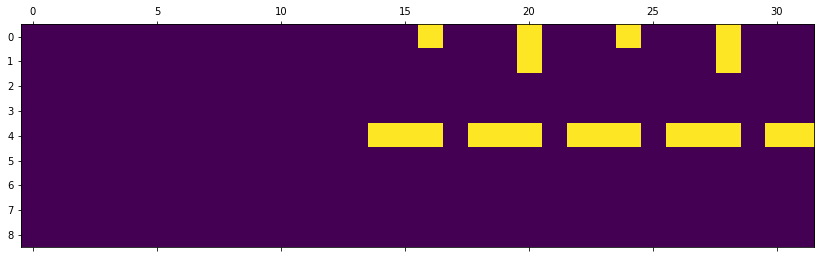

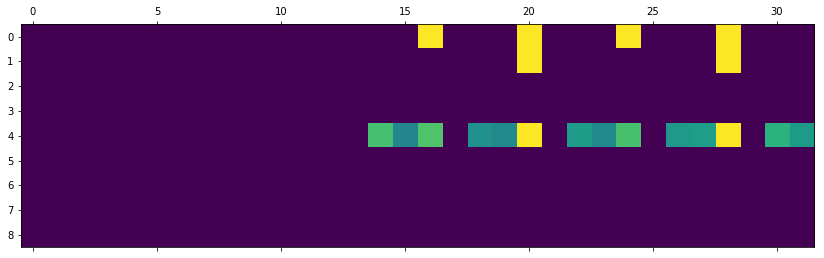

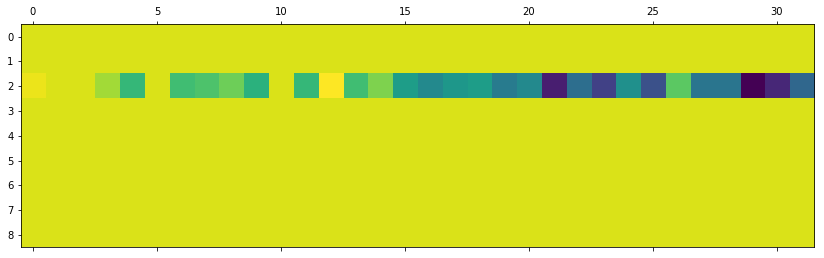

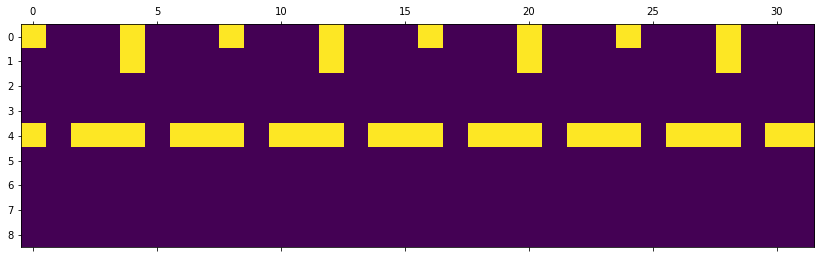

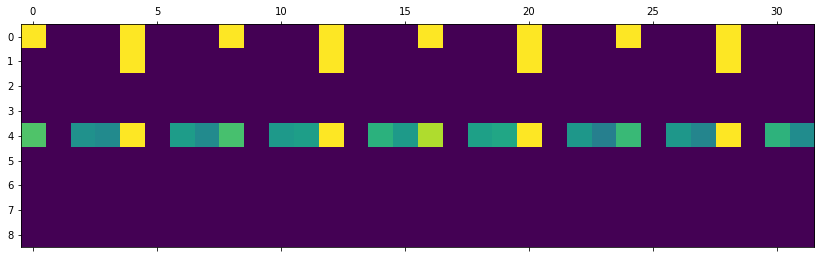

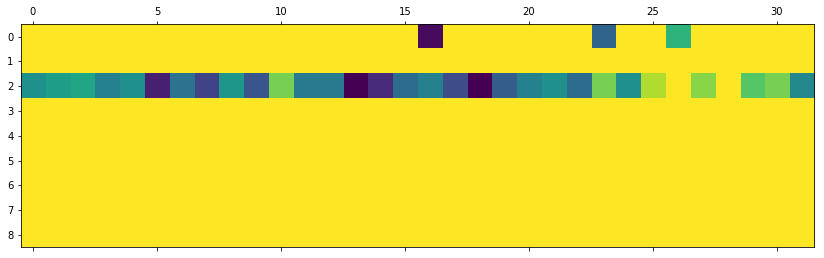

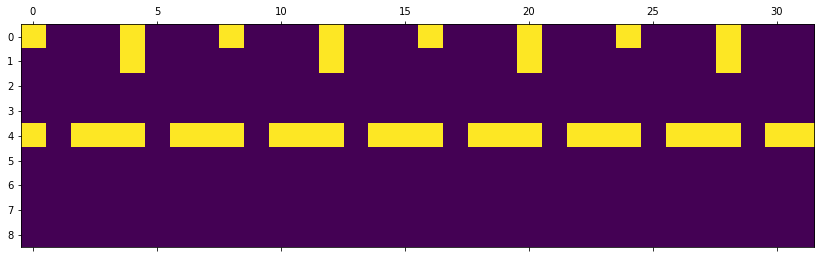

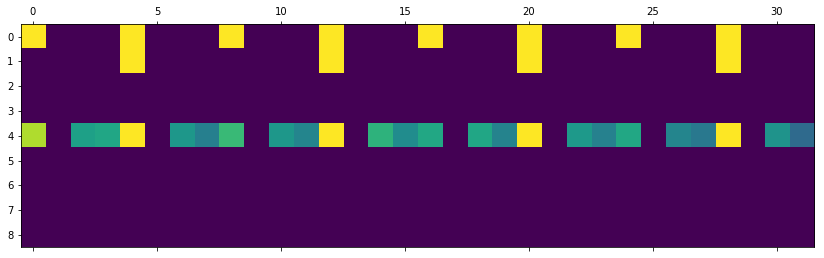

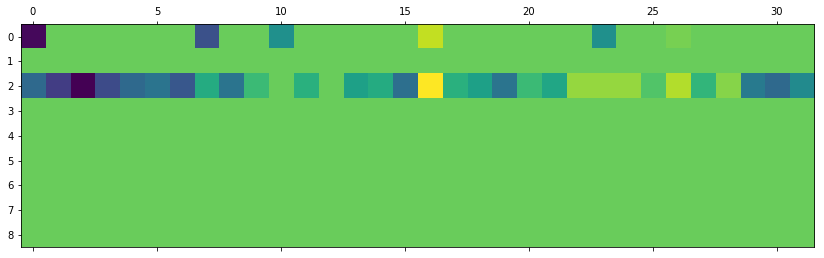

In [9]:
import random
import numpy as np
import os
import joblib
import pretty_midi
import glob

import matplotlib.pyplot as plt
%matplotlib inline

MIN_NB_ONSETS = 5

def plot_drum_matrix(a):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        plt.matshow(a)
        plt.show()  

# unit timestep = 16th note
def get_pianomatrices_of_drums(midi_file, is_drum=True):
    found = False
    genre_id = -1
    
    # is it in selected genres?
    for id_, genre in enumerate(GENRES):
        if genre in midi_file:
            found = True
            genre_id = id_
            break
    if found is False:
        return None
    
    # load midi file
    try:
        pm = pretty_midi.PrettyMIDI(midi_file)
    except:
        print ("Failed to load midi: ", midi_file)
        return None
        
    # get timiming of quater notes
    beats = pm.get_beats()
    
    # make it to 16th notes
    beats_ticks = [] # converting to ticks
    
    for i in range((len(beats) +1)* 4):
        beats_ticks.append(i * pm.resolution / 4)
    
    num_notes16 = len(beats_ticks)
    print(num_notes16, midi_file)
    
    # maximum duration of one note
    max_duration = 2.0 # 2 quater notes

    # convert ticks to index of 16th note
    def find_note_index(tick, beats_ticks):
        return (np.abs(beats_ticks - tick)).argmin()
    
    def get_timeshift(beats_ticks, grid_id, note_start):
        grid_start = beats_ticks[grid_id]
        tick_diff = note_start - grid_start
        tick_grid = pm.resolution / resolution * 0.5 # half of 16th note = 32nd note
        diff_coef= tick_diff / tick_grid   # coef to a half of 16th note
        return diff_coef
        
    # # of notes
    notes_length = 4 * nb_bars * resolution

    # create pianoroll matrix (resolution: 16th note))
    found_extra = False # with other than kick/snare/hat
    onsets, velocities, timeshifts, durations, genre_ids = [], [], [], [], []
    for instrument in pm.instruments:
        if instrument.is_drum == is_drum:  # use drum tracks only
            
            for note_start in range(0, num_notes16 - 16, 16): # hopsize = 1bar = 16 16th notes
                onset = np.zeros((notes_length, nb_notes), dtype='float') 
                velocity = np.zeros((notes_length, nb_notes), dtype='float') 
                timeshift = np.zeros((notes_length, nb_notes), dtype='float')
                duration = np.zeros((notes_length, nb_notes), dtype='float')

                for note in instrument.notes:
                    idx_start = find_note_index(pm.time_to_tick(note.start), beats_ticks)
                    diff_coef = get_timeshift(beats_ticks, idx_start, pm.time_to_tick(note.start))

                    if note_start <= idx_start and idx_start < note_start + notes_length:
                        if note.pitch in MIDI_DRUM_MAP:
                            drum_note = MIDI_DRUM_MAP[note.pitch]
                            
                            onset[idx_start - note_start, drum_note] = 1
                            velocity[idx_start - note_start, drum_note]  = note.velocity / 128.
                            timeshift[idx_start - note_start, drum_note] = diff_coef

                            dur = (pm.time_to_tick(note.end) - pm.time_to_tick(note.start))/ (pm.resolution / 4)
                            dur = min(1.0, max(0, dur / max_duration))
                            duration[idx_start - note_start, drum_note] = dur

                            if drum_note >= 3:
                                found_extra = True
                        else:
                            print("not found", note.pitch )
                
                if np.sum(onset > 0.) >= MIN_NB_ONSETS:
                    onsets.append(onset)
                    velocities.append(velocity)
                    timeshifts.append(timeshift)
                    durations.append(duration)
                    genre_ids.append(genre_id)
             
    # ignore the first and the last one!
    onsets = np.array(onsets)
    velocities = np.array(velocities)
    timeshifts = np.array(timeshifts)
    durations = np.array(durations)
    genre_ids = np.array(genre_ids)
    
    return (onsets,velocities, timeshifts, durations, genre_ids)
    
midi_file = random.choice(filepaths)
onsets, velocities, timeshifts, duration, genre_ids = get_pianomatrices_of_drums(midi_file)    

# sample
print (timeshift.shape)
print (genre_ids.shape)
print (timeshift.shape)

for i in range(min(3, len(drums))):
    plot_drum_matrix(onsets[i])
    plot_drum_matrix(velocities[i])
    plot_drum_matrix(timeshift[i])

# Batch processing

it may take more than an hour. plase be patient!

In [10]:
# Start creating piano-roll matrix
matrices_drums_list = joblib.Parallel(n_jobs=-1, verbose=1)(
   joblib.delayed(get_pianomatrices_of_drums)(midi_file, True)     
     for midi_file in filepaths)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 491 out of 491 | elapsed: 42.7min finished


In [11]:
# clean up! 
matrices_drums_selected = [a for a in matrices_drums_list if a is not None]
matrices_drums_selected = [a for a in matrices_drums_selected
                           if (a[0].shape[0] == a[1].shape[0] and a[1].shape[0] == a[2].shape[0] and a[2].shape[0] == a[3].shape[0] and a[0].shape[0]>0)]

matrices_drums_ = [a[0] for a in matrices_drums_selected] # if a is not None and len(a[0].shape)==3 and a[3].shape[0] == a[0].shape[0]]
matrices_velos_ = [a[1] for a in matrices_drums_selected]
matrices_times_ = [a[2] for a in matrices_drums_selected] # if a is not None and len(a[1].shape)==3 and a[3].shape[0] == a[0].shape[0]]
matrices_durations_ = [a[3] for a in matrices_drums_selected] #if a is not None and len(a[2].shape)==3 and a[3].shape[0] == a[0].shape[0]]
matrices_genre_ids_ = [np.squeeze(a[4]) for a in matrices_drums_selected] #if a is not None and a[3].ndim==1 and a[3].shape[0] == a[0].shape[0]]

matrices_drums = np.vstack(matrices_drums_)
print (matrices_drums.shape)

matrices_velos = np.vstack(matrices_velos_)
print (matrices_velos.shape)

matrices_times = np.vstack(matrices_times_)
print (matrices_times.shape)

matrices_durations = np.vstack(matrices_durations_)
print (matrices_durations.shape)

matrices_genre_ids = np.hstack(matrices_genre_ids_)
print (matrices_genre_ids.shape)



(16657, 32, 9)
(16657, 32, 9)
(16657, 32, 9)
(16657, 32, 9)
(16657,)


## Save preprocessed data

In [13]:
# store data
np.savez("./tmp/matrices_drum_groove_genres.npz", onsets=matrices_drums, velocities=matrices_velos, timeshifts=matrices_times,
         durations=matrices_durations, genre_ids=matrices_genre_ids, genres=GENRES)

## Restore preprocessed data

In [14]:
import numpy as np

matrices_drums = np.load("./tmp/matrices_drum_groove_genres.npz")['onsets']
matrices_genres = np.load("./tmp/matrices_drum_groove_genres.npz")['velocities']
GENRES = np.load("./tmp/matrices_drum_groove_genres.npz")['genres']
NB_GENRES = len(GENRES)

print(GENRES)

print(matrices_genres.shape)

['latin' 'jazz' 'soul' 'hiphop' 'rock' 'funk']
(16657, 32, 9)


## Matrix data -> MIDI Playback

If you haven't installed `fluidsynth`, try `sudo apt-get install fluidsynth`.

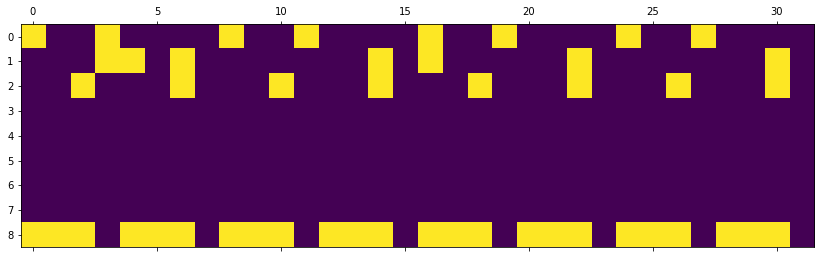

In [15]:
import pretty_midi
import random
from IPython.display import Audio

def play_drum_matrix(mat, tempo=120.0):
    # generate audio
    audio_data = get_audio_from_drum_matrix(mat, tempo=tempo)
    display(Audio(audio_data, rate=44100))
    return audio_data

def get_audio_from_drum_matrix(mat, tempo=120.):
    pm = pretty_midi.PrettyMIDI(initial_tempo=tempo) # midi object
    pm_inst = pretty_midi.Instrument(0, is_drum=True) # midi instrument
    
    timestep = (60./tempo) / 4. # duration of a 16th note
    for position, timeslot in enumerate(mat):
        for inst, onset in enumerate(timeslot):
            if onset > 0.:
                note_number = DRUM_MIDI_MAP[inst]
                velocity = int(onset * 127.)
                start = timestep * position
                end = timestep * (position + 0.5)
                
                # create a midi note
                note = pretty_midi.Note(velocity=velocity, pitch=note_number, start=start, end=end)
                pm_inst.notes.append(note)
    pm.instruments.append(pm_inst)

    # midi -> audio
    audio_data = pm.fluidsynth()
    return audio_data


# test

mat = random.choice(matrices_drums)
plot_drum_matrix(mat)
audio_data = play_drum_matrix(mat, tempo=100.)


from scipy.io import wavfile
wavfile.write("drum.wav", 44100, audio_data)